<a href="https://colab.research.google.com/github/phylypo/TimeSeriesPrediction/blob/main/Time_Series_DL_LSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of Time Series Forecasting from Statistical to Recent ML Approaches 

Topics for this notebook are in bold:
- Introduction to TS
- Decompose (*Time_Series_FFT.ipynb*)
 - Gen Synthic
 - Decompose FFT
- Naive approaches
- Statistical (*Time_Series_ES_ARIMA.ipynb*)
 - Smoothing techniques
 - ARIMA
 - State Space (*Time_Series_StateSpace.ipynb*)
- ML (*Time_Series_ML-LR_XGBoost.ipynb*)
  - Linear Regression
  - Decision Tree (XGBoost)
- **DL (*Time_Series_DL_LSTM_CNN.ipynb*)**
 - **LSTM, CNN + LSTM**
 - TCN (*Time_Series_DL_TCN_LSTNet.ipynb*)
 - LSTNet
 - TFT (*Time_Series_DL_TFT_N-BEATS.ipynb*)
 - N-BEATS
- Commercial: (*Time_Series_Commercial.ipynb*)
 - Facebook Prophet
 - Amazon DeepAR

## Deep Learning

The deep learning approach falls into 3 categories (CNN, RNN, and Transformer or attention based). Here we will look at the general RNN (LSTM specifically) and CNN.


**Convolutional Neural Network (CNN)**

1. Causual Convolution

> $h_t^{l+1} = A(\sum\limits_{\tau=0}^k{W(l,\tau)h_{t-\tau}^l})$
- $h_t^l$ : hidden state at layer $l$ at time $t$
- $W(l,\tau)$: filter weight at layer $l$
- $A$: activation function like sigmoid or relu

2. Dilated Convolution: Dilated convolutions can hence
be interpreted as convolutions of a down-sampled version of the lower layer features – reducing
resolution to incorporate information from the distant past. As such, by increasing the dilation rate
with each layer, dilated convolutions can gradually aggregate information at different time blocks,
allowing for more history to be used in an efficient manner.

> $h_t^{l+1} = A(\sum\limits_{\tau=0}^{\lfloor{k/d_l}\rfloor}{W(l,\tau)h_{t-\tau}^l})$
- $d_l$ dilation rate on specific layer

**Recurrent Neural Network (RNN)**

RNN used as sequence modeling for NLP. It has internal state that summarize the past information and get recursivel udpate with new data at each time step.

- use in sequence modeling  in NLP
- add memory cell in LSTM

> $y_{t+1} = \gamma_y(W_y x_t + b_y)$
> $z_t = \gamma_z ( W_{z_1} z_{t-1} + W_{z_2}y_t + W_{z_3} x_t + W_{z_4}s + b_z )$
- $z_t$: hidden state at time $t$
- $W, b$: linear weigths and biases
- $\gamma$: activation function

**Long Short-Term Memory (LSTM)**

> $z_t = o_t \odot \tanh(c_t)$
- $o_t$: output gate,
- $c_t$: cell state that includes $z_t$

**Attention Mechanisms**

Improvement in long term dependcency learning in NLP. It aggregates temporal features using dynamically genterated weights allow the network to focus on significat time steps in the past in ven far back look back window. Using key-value lookup for a query $q$:

> $h_t = \sum\limits_{\tau=0}^k{\alpha(k_t, q_\tau)v_{t-\tau}}$

> - $k_t$: key
> - $q_\tau$: query
> - $v_{t-\tau}$: intermediate features produced at different time steps
> - $\alpha(k_t,q_\tau)$ : attention weight at time $t$

![](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/02d49b4dbaf8c093034918a76648fea53961753d/2-Figure1-1.png)
Figure 1: Incorporating temporal information using different encoder architectures. <br/>

*("Time Series Forecasting With Deep Learning: A Survey",
Bryan Lim, Stefan)*



### LSTM
Long Short-Term Memory

In [ ]:
# download data file
!curl -O https://assets.digitalocean.com/articles/eng_python/prophet/AirPassengers.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1748  100  1748    0     0   6801      0 --:--:-- --:--:-- --:--:--  6775


In [ ]:
#https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%204%20-%20LSTM.ipynb

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

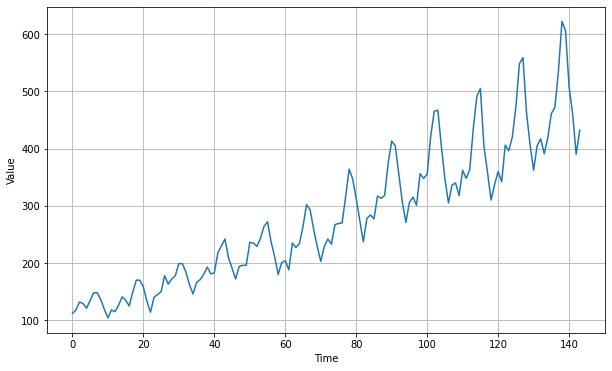

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

import csv
time_step = []
airpass = []

with open('AirPassengers.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  i=0
  for row in reader:
    airpass.append(float(row[1]))
    time_step.append(i)
    i+=1

series = np.array(airpass)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)   

In [ ]:
split_time = 132
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 12
batch_size = 24
shuffle_buffer_size = 24

In [ ]:
x_train = x_train.reshape(132,1)
x_valid = x_valid.reshape(12,1)
print(x_valid.shape)
x_valid_prescale = x_valid

(12, 1)


In [ ]:
#https://github.com/gianfelton/12-Month-Forecast-With-LSTM/blob/master/12-Month%20Forecast%20With%20LSTM.ipynb
# add  scaler -- this seems to help quite a bit
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(1)
np.random.seed(1)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#https://github.com/gianfelton/12-Month-Forecast-With-LSTM/blob/master/12-Month%20Forecast%20With%20LSTM.ipynb
#model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
#model.add(Dropout(0.15))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mse')

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(260, activation='relu', return_sequences=True)),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(248)),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.Adam()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.8)

# to find learning rate
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]) #mae
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

# skip learning rate
#model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])
#history = model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
5/5 [==============================] - 1s 158ms/step - loss: 0.0680 - mae: 0.2626
Epoch 2/100
5/5 [==============================] - 1s 161ms/step - loss: 0.0713 - mae: 0.2596
Epoch 3/100
5/5 [==============================] - 1s 157ms/step - loss: 0.0742 - mae: 0.2861
Epoch 4/100
5/5 [==============================] - 1s 154ms/step - loss: 0.0856 - mae: 0.2928
Epoch 5/100
5/5 [==============================] - 1s 156ms/step - loss: 0.0776 - mae: 0.2717
Epoch 6/100
5/5 [==============================] - 1s 151ms/step - loss: 0.0833 - mae: 0.3034
Epoch 7/100
5/5 [==============================] - 1s 149ms/step - loss: 0.0909 - mae: 0.2986
Epoch 8/100
5/5 [==============================] - 1s 154ms/step - loss: 0.0740 - mae: 0.2687
Epoch 9/100
5/5 [==============================] - 1s 148ms/step - loss: 0.0527 - mae: 0.2454
Epoch 10/100
5/5 [==============================] - 1s 148ms/step - loss: 0.0840 - mae: 0.2957
Epoch 11/100
5/5 [==============================] - 1s 148m

(0.0001, 0.1, 0.0, 2.0)

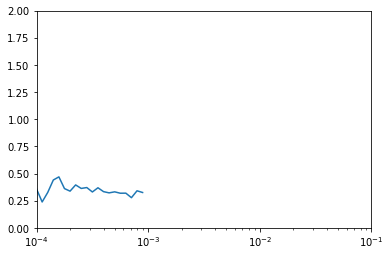

In [ ]:
# find learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 2])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(1)
np.random.seed(1)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])

# model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
# history = model.fit(dataset,epochs=200,verbose=1)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(260, activation='relu', return_sequences=True)),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(248)),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.Adam()
model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset,epochs=100,verbose=1)


Epoch 1/100
5/5 [==============================] - 1s 145ms/step - loss: 38.1041 - mae: 5.0877
Epoch 2/100
5/5 [==============================] - 1s 141ms/step - loss: 6.3022 - mae: 2.0397
Epoch 3/100
5/5 [==============================] - 1s 142ms/step - loss: 0.2784 - mae: 0.4388
Epoch 4/100
5/5 [==============================] - 1s 147ms/step - loss: 1.2762 - mae: 1.0910
Epoch 5/100
5/5 [==============================] - 1s 149ms/step - loss: 0.2816 - mae: 0.4438
Epoch 6/100
5/5 [==============================] - 1s 148ms/step - loss: 0.1309 - mae: 0.2794
Epoch 7/100
5/5 [==============================] - 1s 148ms/step - loss: 0.1123 - mae: 0.3064
Epoch 8/100
5/5 [==============================] - 1s 150ms/step - loss: 0.0846 - mae: 0.2259
Epoch 9/100
5/5 [==============================] - 1s 146ms/step - loss: 0.0334 - mae: 0.1405
Epoch 10/100
5/5 [==============================] - 1s 143ms/step - loss: 0.0553 - mae: 0.2001
Epoch 11/100
5/5 [==============================] - 1s 139

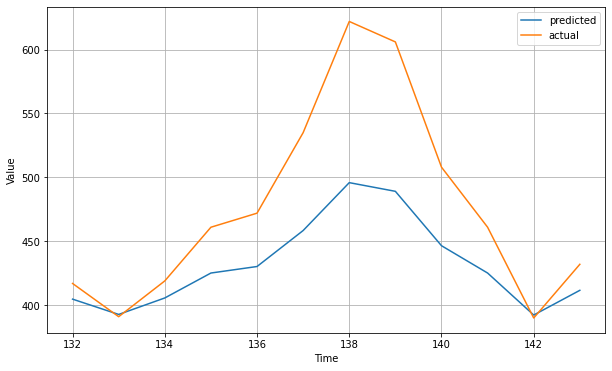

In [ ]:
forecast = []
results = []
for time in range(len(x_valid)):
  forecast.append(model.predict(x_valid[time]))

results = np.array(forecast)[:, 0, 0]
results = results.reshape(12,1)
scaled_results = scaler.inverse_transform(results)
plt.figure(figsize=(10, 6))

plot_series(time_valid, scaled_results)
plot_series(time_valid, x_valid_prescale)
plt.legend(['predicted', 'actual'])
#results

In [ ]:
tf.keras.metrics.mean_absolute_error(scaled_results, x_valid_prescale).numpy().mean()
diff = abs(scaled_results - x_valid_prescale).mean()
print(diff)

45.37401580810547


### CNN + LSTM

1D Conv + LSTM: 
Adding convolution of the input and generate as features inputs the the LSTM.

https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Lesson%205.ipynb#scrollTo=tP7oqUdkk0gY



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

import csv
time_step = []
airpass = []

with open('AirPassengers.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  i=0
  for row in reader:
    airpass.append(float(row[1]))
    time_step.append(i)
    i+=1

series = np.array(airpass)
time = np.array(time_step)
#plt.figure(figsize=(10, 6))
#plot_series(time, series)   

In [ ]:
split_time = 130
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

x_valid_prescale = x_valid
window_size = 12
batch_size = 24
shuffle_buffer_size = 48

In [ ]:
x_train = x_train.reshape(130,1)
x_valid = x_valid.reshape(14,1)
x_valid.shape
x_valid_prescale = x_valid

In [ ]:
# # add  scalaer -- didn't help
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# scaler.fit(x_train)
# x_train = scaler.transform(x_train)
# x_valid = scaler.transform(x_valid)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
    
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 12
batch_size = 24
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  #tf.keras.layers.LSTM(64, return_sequences=True),
  #tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, activation='relu', return_sequences=True)),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True)),
  tf.keras.layers.Dropout(0.15),

  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
optimizer = tf.keras.optimizers.Adam()

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=155, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(130, 1)
Epoch 1/155
5/5 [==============================] - 0s 68ms/step - loss: 4029.4883 - mae: 4029.9880
Epoch 2/155
5/5 [==============================] - 0s 67ms/step - loss: 4173.1787 - mae: 4173.6782
Epoch 3/155
5/5 [==============================] - 0s 67ms/step - loss: 4205.2705 - mae: 4205.7705
Epoch 4/155
5/5 [==============================] - 0s 70ms/step - loss: 3905.3083 - mae: 3905.8079
Epoch 5/155
5/5 [==============================] - 0s 67ms/step - loss: 4002.2793 - mae: 4002.7793
Epoch 6/155
5/5 [==============================] - 0s 68ms/step - loss: 3892.5779 - mae: 3893.0776
Epoch 7/155
5/5 [==============================] - 0s 72ms/step - loss: 4078.1758 - mae: 4078.6758
Epoch 8/155
5/5 [==============================] - 0s 67ms/step - loss: 3921.2764 - mae: 3921.7769
Epoch 9/155
5/5 [==============================] - 0s 68ms/step - loss: 4054.7039 - mae: 4055.2034


185.87110682896204


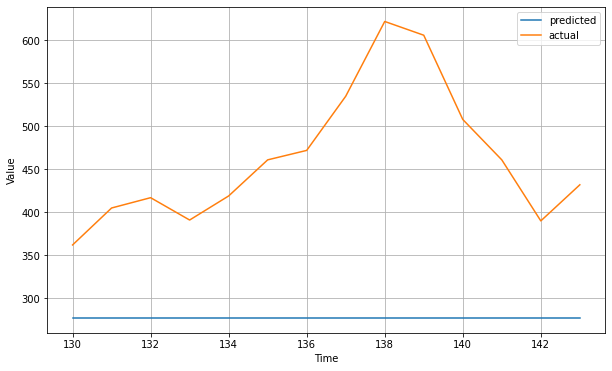

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, rnn_forecast)
plot_series(time_valid, x_valid)
plt.legend(['predicted', 'actual'])
mae = abs(x_valid-rnn_forecast).mean()
print(mae) #59, 61 or dropout 15, 25, mae 56 with 2 drop out 0.15, mae 55: increase dense layer

(1e-08, 0.0001, 0.0, 260.0)

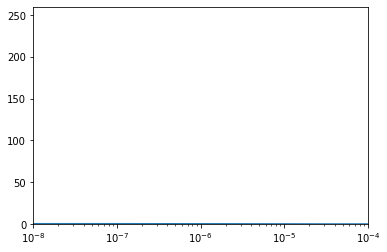

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 260])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 12
batch_size = 24
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

#1D conv + LSTM
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(200, return_sequences=True), #60
  #tf.keras.layers.Dropout(0.15),
  tf.keras.layers.LSTM(200, return_sequences=True), # MAE=17 training with momentum
  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(240, activation='relu', return_sequences=True)),
  #tf.keras.layers.Dropout(0.15),
  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True)),
  tf.keras.layers.Dropout(0.15),

  tf.keras.layers.Dense(200, activation="relu"), #40,60=mae 27,100
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.95) #lr:e-5 -> e-6, mom 0.9 ->0.95
#optimizer = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
5/5 [==============================] - 0s 52ms/step - loss: 253.2706 - mae: 253.7706
Epoch 2/150
5/5 [==============================] - 0s 48ms/step - loss: 171.3441 - mae: 171.8441
Epoch 3/150
5/5 [==============================] - 0s 47ms/step - loss: 103.7105 - mae: 104.2094
Epoch 4/150
5/5 [==============================] - 0s 49ms/step - loss: 96.7117 - mae: 97.2113
Epoch 5/150
5/5 [==============================] - 0s 49ms/step - loss: 104.8138 - mae: 105.3129
Epoch 6/150
5/5 [==============================] - 0s 49ms/step - loss: 95.9726 - mae: 96.4718
Epoch 7/150
5/5 [==============================] - 0s 51ms/step - loss: 89.2046 - mae: 89.7030
Epoch 8/150
5/5 [==============================] - 0s 47ms/step - loss: 86.0602 - mae: 86.5590
Epoch 9/150
5/5 [==============================] - 0s 51ms/step - loss: 79.9563 - mae: 80.4555
Epoch 10/150
5/5 [==============================] - 0s 49ms/step - loss: 74.7858 - mae: 75.2844
Epoch 11/150
5/5 [=======================

result: (12, 1) [[307.1878 ]
 [376.14743]
 [395.44165]
 [375.98578]
 [400.30237]
 [434.8291 ]
 [455.64297]
 [480.93008]
 [507.15714]
 [488.99258]
 [407.69135]
 [366.04913]]
time valid: (12,)


<Figure size 720x432 with 0 Axes>

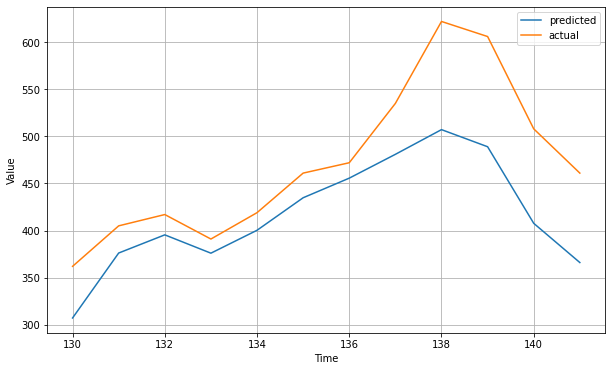

In [ ]:
#rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = model_forecast(model, x_valid[..., np.newaxis], window_size)
#rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

results = np.array(rnn_forecast)[0, :, :]

#print(rnn_forecast)
print("result:", results.shape, results)
time_valid = time_valid[0:12]
print("time valid:", time_valid.shape)
#forecast = results
#results = np.array(forecast)[:]
#results = results.reshape(14,1)
#scaled_results = scaler.inverse_transform(results)
plt.figure(figsize=(10, 6))

plt.figure(figsize=(10, 6))
#plot_series(time_valid, scaled_results)
plot_series(time_valid, results)
plot_series(time_valid, x_valid_prescale[0:12])
plt.legend(['predicted', 'actual'])

In [ ]:
#tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy() #143->121 change learning rate from -e5 to e6
# momen for 0.9 -> 0.95 => loss=86.8

tf.keras.metrics.mean_absolute_error(x_valid_prescale[0:12], results[0:12]).numpy().mean() #143->121 change learning rate from -e5 to e6

55.22022

## Summary

These general deep learning techniques can be a good start but it need a lot of finetune of the hyperparameters. On this simple dataset with not a lot of features, these techniques are tough to beat the classical approaches.

Next will look into more advance deep learning build for time series.